Lina Brisard - Tom Wenlock - Maxime Chetrit - Guillaume Le Hoerff

# [SMART CITIES](smartcities.ipynb)



# Thermal circuit and state-space representation for a thermal circuit with capacities in some nodes: cubic building

**Objectives:**
- Analyse a cubic building with 5 identical walls & a transparent wall (glass window), air infiltration, and HVAC system controlling the indoor air temperature.
- Model the heat transfer in the building by a thermal circuit.
- Obtain the mathematical model as a system of Differential Algebraic Equations (DAE) from the thermal circuit.
- Transfrom the system of DAE into state-space representation.
- Find the steady-state solution.
- Simulate by using Euler methods for numerical integration..

**Boundaries conditions:**

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dm4bem

## Physical analysis

### Description of the building

![Figure1](./Maison.jpg)
> Figure 1. Schéma du système étudié (5 two-layer walls and 1 glass window) equiped with an HVAC system which acts as a proportional controller.

### Electric scheme

![Figure2](./schema_final.jpeg)
> Figure 2. Electric scheme 

The edge lengh of the cube is 5m.
-  $l=5 \: \mathrm{m}$ - edge length of the cube;

We do not take into account the roof and ground. 3 walls are supposed perfectly isolated. Their surface is : 
- $Swall = 5^2$ = 25 m² : 



In [86]:
l=5

The other dimensions and surfaces of the building are : 

- $lwout=2 \: \mathrm{m}$ : length of the concrete wall outside
- $lwin=1.85 \: \mathrm{m}$ : length of the concrete wall inside
- $lwdw =1 \: \mathrm{m}$ : length of the window
- $ldoor =0.9 \: \mathrm{m}$ : length of the door

In [87]:
lwout=2
lwin=1.85
lwdw=1
ldoor=0.9


The other sufaces are : 
- Swout : surface of the concrete wall outdoor
- Swin : surface of the concrete wall indoor
- Swdw : surface of the window
- Sdoor : surface of the door

In [88]:
Swout = lwout*5
Swin = lwin*5
Swdw = lwdw*5
Sdoor=5*ldoor

### Thermo-physical properties
The thermophysical properties of the air (in SI units) are:

In [89]:
air = {'Density': 1.2,                      # kg/m³
       'Specific heat': 1000}               # J/(kg·K)
# pd.DataFrame.from_dict(air, orient='index', columns=['air'])
pd.DataFrame(air, index=['Air'])

,Density,Specific heat
Air,1.2,1000


The [thermophysical properties](https://energieplus-lesite.be/donnees/enveloppe44/enveloppe2/conductivite-thermique-des-materiaux/) ([thermal conductivities](https://en.m.wikipedia.org/wiki/List_of_thermal_conductivities), [densities](https://en.wikipedia.org/wiki/Density) and [specific heat capacities](https://en.m.wikipedia.org/wiki/Table_of_specific_heat_capacities)) and the geometry (widths and surface areas) of the three materials (i.e., concrete, insulation, glass) in SI units are:

In [90]:
concrete = {'Conductivity': 1.400,
            'Density': 2300.0,
            'Specific heat': 880,
            'Width': 0.2,
            'Surfacein': lwin*5,
            'Surfaceout': lwout*5}

insulation = {'Conductivity': 0.027,
              'Density': 55.0,
              'Specific heat': 1210,
              'Width': 0.20,
              'Surface': 5 * lwout}

glass = {'Conductivity': 1.4,
         'Density': 2500,
         'Specific heat': 1210,
         'Width': 0.04,
         'Surface': lwdw*5}

wood = {'Conductivity': 0.16,
         'Density': 350,
         'Specific heat': 1700,
         'Width': 0.04,
         'Surface': ldoor*5}

'''wall = pd.DataFrame.from_dict({'Layer_out': insulation,
                               'Layer_in': concrete,
                               'Glass': glass
                               'Door': wood},
                              orient='index')'''

"wall = pd.DataFrame.from_dict({'Layer_out': insulation,\n                               'Layer_in': concrete,\n                               'Glass': glass\n                               'Door': wood},\n                              orient='index')"

In [91]:
# radiative properties

α_glass = 0.38    # short wave absortivity: reflective blue glass

The [Stefan-Boltzmann constant](https://en.m.wikipedia.org/wiki/Stefan–Boltzmann_constant) is:

In [92]:
σ = 5.67e-8     # W/(m²⋅K⁴) Stefan-Bolzmann constant
print(f'σ = {σ} W/(m²⋅K⁴)')

σ = 5.67e-08 W/(m²⋅K⁴)


### Convection coefficients

Conventional values for the [convection coeficients](https://energieplus-lesite.be/theories/enveloppe9/echanges-chaleur-parois/resistance-thermique-d-echange-superficiel/) for indoor and outdoor convection in W/(m²⋅K) are:

In [93]:
# convection coefficient

hindoor=8 # W/(m²⋅K)
houtdoor=25 # W/(m²⋅K)

## Thermal circuit

Heat transfert is:
- through the walls (concrete and insulation), 
- through the glass window,
- by ventilation,
- from indoor auxiliary sources,
- from the HVAC system.

The HVAC system is modelled as a proportional controller. There is long wave radiative exchange between the wall and the glass window. The sources are:
- temperature sources:
    - outdoor atmospheric air;
    - indoor air temperature setpoint;
- flow rate sources:
    - solar radiation on the outdoor and the indoor walls;
    - auxiliary heat gains in the thermal zone.


### Thermal conductances
#### Conduction
 Conduction conductances, in W/K, are of the form:
$$G_{cd} = \frac{\lambda}{w}S$$
where:

- $\lambda$ - [thermal conductvity](https://en.m.wikipedia.org/wiki/Thermal_conductivity), W/(m⋅K);
- $w$ - width of the material, m;
- $S$ - surface area of the wall, m².

In [94]:
# conduction

Gcond0=concrete['Conductivity']*concrete['Surfaceout']/concrete['Width']
Gcond1=insulation['Conductivity']*insulation['Surface']/insulation['Width']
Gcond3=glass ['Conductivity']*glass ['Surface']/glass ['Width']
Gcond4=Gcond3
Gcond5=concrete['Conductivity']*concrete['Surfacein']/concrete['Width']
Gcond6=Gcond5
Gcond7=Gcond1
Gcond8=Gcond0

#### Convection
The conductances 0, 6 and 7 model the heat transfer by [convection](https://en.m.wikipedia.org/wiki/Convection_(heat_transfer). Convection conductances, in W/K, are of the form:
$$G_{cv} = {h S}$$
where:
- $h$ is the [convection coefficient](https://en.m.wikipedia.org/wiki/Heat_transfer_coefficient), W/(m²⋅K);
- $S$ - surface area of the wall, m². 

In [95]:
# convection

Gconv0= houtdoor*concrete['Surfaceout']
Gconv1=hindoor*insulation['Surface']
Gconv2=hindoor*wood['Surface']
Gconv3=hindoor*glass['Surface']
Gconv4=houtdoor*glass['Surface']
Gconv5=hindoor*concrete['Surfacein']
Gconv6=hindoor*concrete['Surfacein']
Gconv7=hindoor*insulation['Surface']
Gconv8=houtdoor*concrete['Surfaceout']


#### Advection

The [volumetric flow rate](https://en.m.wikipedia.org/wiki/Volumetric_flow_rate) of the air, in m³/s, is:

$$\dot{V}_a = \frac{\mathrm{ACH}}{3600} V_a$$

where:
- $\mathrm{ACH}$  ([air changes per hour](https://en.m.wikipedia.org/wiki/Air_changes_per_hour)) is the air infiltration rate, 1/h;
- $3600$ - number of seconds in one hour, s/h;
- $V_a$ - volume of the air in the thermal zone, m³.

In [96]:
# ventilation flow rate
Va = l**3                   # m³, volume of air
ACH = 1                     # air changes per hour
Va_dot = ACH / 3600 * Va    # m³/s, air infiltration

The net flow rate that the building receives by [advection](https://en.m.wikipedia.org/wiki/Advection), i.e., introducing outdoor air at temperature $T_o$ and extracting indoor air at temperature $\theta_i$ by [ventilation](https://en.m.wikipedia.org/wiki/Ventilation_(architecture)) and/or [air infiltration](https://en.m.wikipedia.org/wiki/Infiltration_(HVAC)), is:

$$q_v = \dot{m}_a c_a (T_o - \theta_i) = \rho_a c_a \dot{V}_a (T_o - \theta_i)$$

where:
- $\dot{m}_a$ is the [mass flow rate](https://en.m.wikipedia.org/wiki/Mass_flow_rate) of air, kg/s;
- $\dot{V}_a$ - [volumetric flow rate](https://en.m.wikipedia.org/wiki/Volumetric_flow_rate), m³/s;
- $c_a$ - [specific heat capacity](https://en.m.wikipedia.org/wiki/Specific_heat_capacity) of the air, J/kg·K;
- $\rho_a$ - [density](https://en.m.wikipedia.org/wiki/Density) of air, kg/m³;
- $T_o$ - outdoor air temperature, °C (noted in majuscule because it is a *temperature source* or *input variable*);
- $\theta_i$ - indoor air temperature, °C (noted in minuscule because it is a *dependent temperature* or *output variable*).

Therefore, the conductance of [advection](https://en.m.wikipedia.org/wiki/Advection) by [ventilation](https://en.m.wikipedia.org/wiki/Ventilation_(architecture)) and/or [infiltration](https://en.m.wikipedia.org/wiki/Infiltration_(HVAC)), in W/K, is:

$$G_v = \rho_a c_a \dot{V}_a$$

#### Proportional controller

In the simplest representation, the [HVAC system](https://en.m.wikipedia.org/wiki/HVAC_control_system) can be considered as a [proportional controller](https://en.m.wikipedia.org/wiki/Proportional_control) that adjusts the heat flow rate $q_{HVAC}$ in order to control the indoor temperature $\theta_i$ at its setpoint value $T_{i,sp}$. The heat flow-rate, in W, injected by the [HVAC](https://en.m.wikipedia.org/wiki/Heating,_ventilation,_and_air_conditioning) system into the controlled space is:

$$ q_{HVAC} = K_p (T_{i, sp} - \theta_i)$$

where:
- $K_p$ is the proportional gain, W/K;
- $T_{i, sp}$ - indoor temperature [setpoint](https://en.m.wikipedia.org/wiki/Setpoint_(control_system)), °C (noted in majuscule because it is an *input, i.e. independent, variable*);
- $\theta_i$ - indoor temperature, °C (noted in minuscule because it is a *output, i.e. dependent variable*).

This equation shows that the proportional controller can be modelled by a source of temperature, $T_{i, sp}$, and a conductance, $K_p$. If the controller gain tends towards:
- infinity, $K_p \rightarrow \infty$, then the controller is perfect, $\theta_i \rightarrow T_{i, sp}$.
- zero, $K_p \rightarrow 0$, then the controller is not acting and the building is in free-running, i.e. $q_{HVAC} = 0$ ([Ghiaus 2003](https://doi.org/10.1016/S0378-7788(02)00110-X)).

*Note*: Respecting the [sign convention](https://en.m.wikipedia.org/wiki/Passive_sign_convention#Active_and_passive_components), the flow rate $q_{HVAC}$ is oriented from the lower to the higher potential of the temperature source $T_{i,sp}$.

In [97]:
# P-controler gain

K3 = K10 = 0            # For now, we suppose that the controller is not active : Kp -> 0

### Thermal capacities
#### Walls
The [thermal capacities](https://en.m.wikipedia.org/wiki/Heat_capacity) of the wall, in J/kg, are:

$$C_w= m_w c_w= \rho_w c_w w_w S_w$$

where:
- $m_w = \rho_w w_w S_w$ is the mass of the wall, kg;
- $c_w$ - [specific heat capacity](https://en.m.wikipedia.org/wiki/Specific_heat_capacity), J/(kg⋅K);
- $\rho_w$ - [density](https://en.m.wikipedia.org/wiki/Density), kg/m³;
- $w_w$ - width of the wall, m;
- $S_w$ - surface area of the wall, m².

In [98]:
# Wall thermal capacities

C1concrete = concrete['Density']*concrete['Specific heat']*concrete['Width']*concrete['Surfaceout']
C1insulation = insulation['Density']*insulation['Specific heat']*insulation['Width']*insulation['Surface']
C1= C1concrete + C1insulation #left wall

C5=  concrete['Density']*concrete['Specific heat']*concrete['Width']*concrete['Surfacein']   #middle wall
C7= C1  #right wall

#### Air
Similarly, the thermal capacity of the air, in J/kg, is:

$$C_a = m_a c_a = \rho_a c_a V_a$$

where:
- $m_a = \rho_a V_a$ is the mass of the air, kg;
- $\rho_w$ - [density](https://en.m.wikipedia.org/wiki/Density) of air, kg/m³;
- $c_a$ - specific heat capacity of the air, J/(kg⋅K);
- $V_a$ - volume of the air in the thermal zone, m³.

In [99]:
# Air thermal capacities

Vleft_room = 3*4.6*5
Vright_room = 1.8*4.6*5

C2= air['Density'] * air['Specific heat'] * Vleft_room

C6= air['Density'] * air['Specific heat'] * Vright_room

### Temperature sources

The outdoor air temperature is supposed homogeneous and equal to 10°C.

We define the desired indoor air temperature as 20°C. (set point temperature)

In [100]:
# Temperature sources

T0=10
Ti_sp=20

### Heat flow rate sources
The [heat flow rate sources](https://en.m.wikipedia.org/wiki/Current_source#Background) model flow rates which vary idependently of what happens in the themal circuit. They are inputs of the physical model. Generally, the heat flow rate sources are:
- solar radiation absorbed by the walls;
- internal auxiliary sources.

#### Solar radiation absorbed by the walls

The [direct](https://en.m.wikipedia.org/wiki/Direct_insolation), diffuse and reflected components of the [solar radiation](https://en.m.wikipedia.org/wiki/Solar_irradiance) on a tilted surface can be estimated from weather data by using the function `sol_rad_tilt_surf` from the module `dm4bem` (see the tutorial on [Weather data and solar radiation](../t01/t01ReadWeatherData.ipynb)).

##### External wall

The radiation absorbed by the outdoor surface of the wall is:

$$\Phi_o = \alpha_{w,SW} S_w E_{tot}$$

where:
- $\alpha_{w,SW}$ is the [absorptance](https://en.m.wikipedia.org/wiki/Absorptance) of the outdoor surface of the wall in short wave, $0 \leqslant \alpha_{w,SW} \leqslant 1$;
- $S_w$ - surface area of the wall, m²;
- $E_{tot}$ - total [solar irradiance](https://en.m.wikipedia.org/wiki/Solar_irradiance) on the wall, W/m².

In [101]:
alpha_concrete = 0.5
alpha_glass = 0.38   
Etot=1000

phi0= alpha_concrete*Etot*concrete['Surfaceout']
phi4= alpha_glass*Etot*glass['Surface']
phi8= phi0

##### Internal wall

In an initial approach, the internal wall flows are neglected

#### Internal sources

Internal flow rates are generated by occupants and by the electrical equipment (with values given for [offices](https://energieplus-lesite.be/theories/bilan-thermique44/charges-thermiques-internes-pour-les-bureaux/), [commercial spaces](https://energieplus-lesite.be/theories/bilan-thermique44/charges-thermiques-internes-pour-les-commerces/), etc.).

In [102]:
phi2=1000  
phi6= phi2

We chose this value for phi2 and phi6 because it takes into account the radiative flux from people (around 400 W), and the radiative flux from electrical devices (around 600 W). 

## System of algebraic-differential equations (DAE)

The analysis of a thermal circuit, or the direct problem ([Ghiaus 2022](https://hal.archives-ouvertes.fr/hal-03484064/document)), means to find the temperatures in the nodes, $\theta$, and the heat flows on the branches, $q$, i.e. to solve for $\theta$ and $q$ the system of [Differential-Algebraic Equations (DAE)](https://en.m.wikipedia.org/wiki/Differential-algebraic_system_of_equations) (Figures 3 and 4):

$$\left\{\begin{array}{ll}
C \dot{\theta} = -(A^T G A) \theta + A^T G b + f\\ 
q = G (-A \theta + b)
\end{array}\right.$$

where:
- $\theta$ - temperature vector.
- $q$ - heat flow vector.
- $A$ - incidence matrix.

- $G$ - conductance matrix.

- $C$ - capacity matrix.

- $b$ - temperature source vector.

- $f$ - heat flow source vector.

The resolution is first done for temperatures, $\theta$, by solving the equation
$$C \dot{\theta} = -(A^T G A) \theta + A^T G b + f$$
which, generally, is a system of differential-algebraic equations (DAE). Then, the heat flow rates are found from the equation
$$q = G (-A \theta + b)$$



### A: incidence matrix

The [incidence matrix](https://en.m.wikipedia.org/wiki/Incidence_matrix) is:

$A_{kl} = \begin{cases}\phantom{-}
0 & \text{if branch } q_k \text{ is not connected to node }  \theta_l \\ 
+1 & \text{if branch } q_k \text{ enters into node }  \theta_l\\ 
-1 & \text{if branch } q_k \text{ gets out of node }  \theta_l 
\end{cases}$

In [103]:
A = np.zeros([14,9])
A[0,0] = 1
A[1,0], A[1,1] = -1, 1
A[2,1], A[2,2] = -1, 1
A[3,2] = 1
A[4,4] = 1
A[5,3], A[5,4] = 1, -1
A[6,2], A[6,3] = 1, -1
A[7,2], A[7,5] = -1, 1
A[8,5], A[8,6] = -1, 1
A[9,2], A[9,6] = -1, 1
A[10,6] = 1
A[11,8] = 1
A[12,7], A[12,8] = 1, -1
A[13,6], A[13,7] = 1, -1

print(A)

[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  1. -1.  0.  0.  0.  0.]
 [ 0.  0.  1. -1.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  1.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  1. -1.]
 [ 0.  0.  0.  0.  0.  0.  1. -1.  0.]]


### G: conductance matrix

It is a diagonal matrix of size $n_q \times n_q$,  where $n_q$ is the number of flow branches: diagonal matrix containing the conductances. 

Each branch $k$ needs to contain a conductance $0 < G_{k,k} < \infty $. 

In [104]:
G=np.zeros([14,14])
G[0,0] = Gconv0
G[1,1] = Gcond0
G[2,2] = Gcond1 + Gconv1
G[3,3] = K3
G[4,4] = Gconv4
G[5,5] = Gcond4
G[6,6] = Gcond3 + Gconv3
G[7,7] = Gcond5 + Gconv5
G[8,8] = Gcond6 + Gconv6
G[9,9] = Gconv2
G[10,10] = K10
G[11,11] = Gconv8
G[12,12] = Gcond8
G[13,13] = Gcond7 + Gconv7

print(G)

[[250.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.  ]
 [  0.    70.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.  ]
 [  0.     0.    81.35   0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.  ]
 [  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.  ]
 [  0.     0.     0.     0.   125.     0.     0.     0.     0.     0.
    0.     0.     0.     0.  ]
 [  0.     0.     0.     0.     0.   175.     0.     0.     0.     0.
    0.     0.     0.     0.  ]
 [  0.     0.     0.     0.     0.     0.   215.     0.     0.     0.
    0.     0.     0.     0.  ]
 [  0.     0.     0.     0.     0.     0.     0.   138.75   0.     0.
    0.     0.     0.     0.  ]
 [  0.     0.     0.     0.     0.     0.     0.     0.   138.75   0.
    0.     0.     0.     0.  ]
 [  0.     0.     0.     0.     0.     0.     0.     0.     0.    36.
    0.     0.     0. 

### C: capacity matrix
It is a diagonal matrix of size $n_θ \times n_θ$,  where $n_θ$ is the number of temperature nodes.

G contains the capacities at each node. If there is no capacity in the node *n*, then $C_{n, n} = 0$.

In [105]:
C=np.zeros([9,9])
C[1,1] = C1
C[2,2] = C2
C[5,5] = C5
C[6,6] = C6
C[7,7] = C7

print(C)

[[      0.       0.       0.       0.       0.       0.       0.       0.
        0.]
 [      0. 4181100.       0.       0.       0.       0.       0.       0.
        0.]
 [      0.       0.   82800.       0.       0.       0.       0.       0.
        0.]
 [      0.       0.       0.       0.       0.       0.       0.       0.
        0.]
 [      0.       0.       0.       0.       0.       0.       0.       0.
        0.]
 [      0.       0.       0.       0.       0. 3744400.       0.       0.
        0.]
 [      0.       0.       0.       0.       0.       0.   49680.       0.
        0.]
 [      0.       0.       0.       0.       0.       0.       0. 4181100.
        0.]
 [      0.       0.       0.       0.       0.       0.       0.       0.
        0.]]


### b: temperature source vector

The vector of *temperature sources* is $b$, of size $n_q$, the number of branches (in this example 12). An element of the vector $b$ corresponding to a branch without a source is zero. If the flow in a source is from the low potential to the high potential of the source (i.e. from - to +), then the source is positive. If the flow rate in the temperature source is from high potential to low potential (i.e. from + to -), then the source is negative (see [passive sign convention](https://en.m.wikipedia.org/wiki/Passive_sign_convention)). 

For the thermal circuit shown in Figure 3,

$$b = [\begin{matrix}
T_o &0  &0  &0  &0  &0  &0  &0  &T_o  &0  &T_o  &T_{i,sp} 
\end{matrix}]^T$$

i.e. $b_0 = b_8 = b_{10} = T_o$ and $b_{11} = T_{i,sp}$ where:
- $T_o$ is the outdoor temperature, °C. We choose $T_o$= 10°C.
- $T_{i,sp}$ - set-point temperaure for the indoor air, °C. We choose $T_{i,sp}$= 20°C.

Since the temperature sorces $T_o$ and $T_{i,sp}$ are [time series](https://en.m.wikipedia.org/wiki/Time_series), in vector $b$ the branches which contain temperature sources are designated by $1$ and the branches without any temeprature source by $0$.

In [106]:
b=np.zeros(14)
b[[0, 3, 4, 10, 11]] = 1


bT=np.zeros(14)
bT[0]=T0
bT[3]=Ti_sp
bT[4]=T0
bT[10]=Ti_sp
bT[11]=T0

print(bT)

[10.  0.  0. 20. 10.  0.  0.  0.  0.  0. 20. 10.  0.  0.]


### f: heat flow source vector

The vector of *heat sources* is $f$, of size $n_{\theta}$, the number of nodes (in this example 8). An element of the vector $f$ corresponding to a node without a heat source is zero.

For the thermal circuit shown in Figure 3,

$$f = [\begin{matrix}
\Phi_o &0  &0  &0  &\Phi_i  &0  &\dot{Q_a} &\Phi_a 
\end{matrix}]^T$$

i.e. $f_0 = \Phi_o$, $f_4 = \Phi_i$, $f_6 = \dot{Q_a}$, and $f_7 = \Phi_a$, where:
- $\Phi_o$ - solar radiation absorbed by the outdoor surface of the wall, W;
- $\Phi_i$ - solar radiation absorbed by the indoor surface of the wall, W  : neglected.
- $\dot{Q}_a$ - auxiliary heat gains (i.e., occupants, electrical devices, etc.), W;
- $\Phi_a$ - solar radiation absorbed by the glass, W.

Since the flow rate sorces $\Phi_o$, $\Phi_i$, $\dot{Q}_a$ and $\Phi_a$ are [time series](https://en.m.wikipedia.org/wiki/Time_series), in vector $f$ the nodes which contain flow rate sources are designated by $1$ and the  nodes without any flow rate source by $0$.

In [107]:
f = np.zeros(9)
f[[0, 2, 4, 6, 8]] = 1

fQ=np.zeros(9)
fQ[0]=phi0
fQ[2]=phi2
fQ[4]=phi4
fQ[6]=phi6
fQ[8]=phi8

print(fQ)

[5000.    0. 1000.    0. 1900.    0. 1000.    0. 5000.]


### y: output vector

The vector of outputs is $y$, of size $n_{\theta}$, the number of nodes (in this example 8). The non-zero values of $y$ indicate the nodes which are the outputs of the model.

For our thermal circuit, if the output is the indoor air temperature, then the output vector is:

$$y = [\begin{matrix}
0  &0  &\theta_2  &0  &0  &0  &\theta_6 &0 &0
\end{matrix}]^T$$

In vector $y$, the nodes for which the temperatures are outputs are noted by $1$ and the other nodes by $0$.

In [108]:
y = np.zeros(9)         # nodes
y[[2,6]] = 1              # nodes (temperatures) of interest
print(f'y = ', y)

y =  [0. 0. 1. 0. 0. 0. 1. 0. 0.]


## State-space representation
The [differential-algebraic system of equations (DAE)](https://en.m.wikipedia.org/wiki/Differential-algebraic_system_of_equations)

$$C \dot{\theta} = -(A^T G A) \theta + A^T G b + f$$

is transformed in [state-space representation](https://en.m.wikipedia.org/wiki/State-space_representation) ([Ghiaus 2013](https://hal.archives-ouvertes.fr/hal-03605823/document)):

$$\left\{\begin{array}{rr}
\dot{\theta}_s=A_s \theta_s + B_s u\\ 
y = C_s \theta_s + D_s u
\end{array}\right.$$

where:
- $\theta_s$ is the vector of state variables which are the temperatures of nodes containing capacities; the elements are in the same order as in the vector of temperatures, $\theta$; its dimension, $\dim \theta_s$, is equal to the number of capacities from the thermal network; for the circuit presented in Figure 3, $\theta_s = [\theta_1, \theta_3, \theta_6, \theta_7]^T$;

- $u = \begin{bmatrix} b_T \\ f_Q\end{bmatrix}$ - vector of inputs of dimension $\dim u$ equal to the number of sources (of temperaure, $b_T$, and heat flows, $f_Q$) of the thermal network, where:

    - vector $b_T$ of nonzero elements of vector $b$ of temperature sources; for the circuit presented in Figure 3, $b_T = [T_o, T_o, T_o, T_{i,sp}]^T$ corresponds to branches 0, 8, 10 and 11; 
    - vector $f_Q$ of nonzero elements of vector $f$ of flow sources; for the circuit presented in Figure 3, $f_Q = [\Phi_o, \Phi_i, \dot{Q}_a, \Phi_a]^T$ corresponds to nodes 0, 4, 6, and 7;
    
- $y$ - vector of outputs, a subset of vector $\theta$ representing temperature nodes which are of interest; for the circuit presented in Figure 3, $y = \theta_6$, the indoor temperature.

- $A_s$ - state matrix, of dimension $\dim A_s = \dim {\theta_s} \times \dim {\theta_s}$;

- $B_s$ - input matrix, of dimension $\dim B_s = \dim {\theta_s} \times \dim u$;

- $C_s$ - output matrix, of dimension $\dim C_s = \dim y \times \dim {\theta_s}$;

- $D_s$ - feedthrough (or feedforward) matrix, of dimension $\dim D_s = \dim y \times \dim u$.

*Note*: The subscript $s$ of the matrices $A_s, B_s, C_s, D_s$ is used to differentiante the matrices $A_s, C_s$ of the state-space represenation of the matrices $A, C$ of the system of DAE.

The [state-space representation](https://en.m.wikipedia.org/wiki/State-space_representation), i.e., matrices $A_s, B_s, C_s, D_s$ is obtained from the system of DAE, i.e., matrices and vectors $A, G, b, C, f, y$ ([Ghiaus 2013](https://hal.archives-ouvertes.fr/hal-03605823/document)).

In [109]:
[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, b, C, f, y)
print('As = \n', As, '\n')
print('Bs = \n', Bs, '\n')
print('Cs = \n', Cs, '\n')
print('Ds = \n', Ds, '\n')

As = 
 [[-3.25362943e-05  1.94566023e-05  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 9.82487923e-04 -3.75060474e-03  1.67572464e-03  4.34782609e-04
   0.00000000e+00]
 [ 0.00000000e+00  3.70553360e-05 -7.41106719e-05  3.70553360e-05
   0.00000000e+00]
 [ 0.00000000e+00  7.24637681e-04  2.79287440e-03 -5.15499195e-03
   1.63747987e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.94566023e-05
  -3.25362943e-05]] 

Bs = 
 [[1.30796919e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 5.23187678e-08 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 6.57609570e-04 0.00000000e+00
  0.00000000e+00 0.00000000e+00 1.20772947e-05 5.26087656e-06
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.000000

## Steady-state
[Steady-state](https://en.m.wikipedia.org/wiki/Steady_state) means that the term $C \dot \theta = 0$ in the system of DAE.

In [steady-state](https://en.m.wikipedia.org/wiki/Steady_state), the model can be checked if it is incorrect. Let's consider that:
- the controller is not active, $K_p \rightarrow 0$,
- the outdoor temperature is $T_o = 10 \, \mathrm{^\circ C}$,
- the indoor temperature setpoint is $T_{i,sp} = 20 \, \mathrm{^\circ C}$,
- all flow rate sources are zero.

In [110]:
b = np.zeros(14) 
b[[0, 4, 11]] = 10
b[[3, 10]] = 20

K3 = K10 = 0
f = np.zeros(9)         # flow-rate sources

### System of Diferential Algebraic Equations (DAE)
The value of temperature in [steady-state](https://en.m.wikipedia.org/wiki/Steady_state) is obtained from the system of DAE by considering that $C \dot{\theta} = 0$:

$$\theta_{ss} = (A^T G A)^{-1}(A^T G b + f)$$

For the conditions mentioned above, in steady-state, all temperatures  including the indoor air temperature, are equal to $T_o = 10 \, \mathrm{^\circ C}$.

In [111]:
θ = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)
print(f'θ = {θ} °C')

θ = [10. 10. 10. 10. 10. 10. 10. 10. 10.] °C


### State-space representation
The input vector $u$ is obtained by stacking the vectors $b_T$ and $f_Q$:

$$u = \begin{bmatrix} b_T \\ f_Q\end{bmatrix}$$

where:
- $b_T$ is a vector of the nonzero elements of vector $b$ of temperature sources. For the circuit presented in Figure 3, $b_T = [T_o, T_{i,sp}, T_o, T_{i,sp} T_o]^T$ corresponding to branches 0, 3, 4, 10 and 11, where:
    - $T_o$ - outdoor temperature, °C;
    - $T_{i,sp}$ - set-point temperaure for the indoor air, °C.
- $f_Q$ - vector the nonzero elements of vector $f$ of flow sources. For the circuit presented in Figure 3, $f_Q = [\Phi_o, \Phi_i, \dot{Q}_a, \Phi_a]^T$ corresponding to nodes 0, 4, 6, and 7, where:
    - $\Phi_o$ - solar radiation absorbed by the outdoor surface of the wall, W;
    - $\Phi_i$ - solar radiation absorbed by the indoor surface of the wall, W;
    - $\dot{Q}_a$ - auxiliary heat gains (i.e., occupants, electrical devices, etc.), W;
    - $\Phi_a$ - solar radiation absorbed by the glass, W.

*Note*: Zero in vectors $b$ and $f$ indicates that there is no source on the branch or in the node, respectively. However, a source can have the value zero.

In [112]:
bT = np.array([10, 20, 10, 20, 10])     # [To, Tisp, To, Tisp, To]
fQ = np.array([0, 0, 0, 0, 0])    # [Φo, Φi, Qa, Φa]

u = np.hstack([bT, fQ])
print(f'u = {u}')

u = [10 20 10 20 10  0  0  0  0  0]


The steady-state value of the output of the state-space representation is obtained when $\dot \theta_{C} = 0$:

$$y_{ss} = (-C_s A_s^{-1} B_s + D_s) u$$

In [113]:
yss = (-Cs @ np.linalg.inv(As) @ Bs + Ds) @ u
print(f'yss = {yss} °C')

yss = [10. 10.] °C


The error between the steady-state values obtained from the system of DAE, $\theta_6$, and the output of the state-space representation, $y_{ss}$, 

$$\varepsilon = \left | \theta_6 - y_{ss} \right |$$

is practically zero; the slight difference is due to [numerical errors](https://en.m.wikipedia.org/wiki/Numerical_error).

In [114]:
print(f'Max error between DAE and state-space: \
{max(abs(θ[6] - yss)):.2e} °C')

Max error between DAE and state-space: 1.42e-14 °C


## Dynamic simulation

### Time step

The condition for [numerical stability](https://en.m.wikipedia.org/wiki/Euler_method#Numerical_stability) of [Euler explicit integration](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Euler_method) method is

$$\left |  \lambda_i \Delta t + 1 \right | < 1, \forall \lambda_i, $$

i.e. in the complex plane, $\lambda_i \Delta t$ is inside a circle of radius 1 centered in {-1, 0j}, where:
- $\lambda_i$ are the eigenvalues of matrix $A_s$,
- $\Delta t$ - time step.

For positive real eigenvalues $\left \{ \lambda \in \Re |\lambda >0  \right \}$, which is the case of thermal networks, the above condition [becomes](http://www.math.iit.edu/~fass/478578_Chapter_4.pdf)

$$- \lambda_i \Delta t - 1  < 1, \forall \lambda_i, $$

or

$$ 0 < \Delta t < -\frac{2}{\min \lambda_i} = 2 \min -\frac{1}{\lambda_i} = 2 \min T_i$$

where $T_i$ are the [time constants](https://en.m.wikipedia.org/wiki/Time_constant), $T_i = - \frac{1}{\lambda_i} $

In [115]:
λ = np.linalg.eig(As)[0]    # eigenvalues of matrix As

print('Time constants: \n', -1 / λ, 's \n')
print('2 x Time constants: \n', -2 / λ, 's \n')
dtmax = 2 * min(-1. / λ)
print(f'Maximum time step: {dtmax:.2f} s = {dtmax / 60:.2f} min')

Time constants: 
 [  186.32939105   278.3598218  21860.14460234 82417.10601192
 36246.50577441] s 

2 x Time constants: 
 [   372.6587821     556.7196436   43720.28920468 164834.21202385
  72493.01154881] s 

Maximum time step: 372.66 s = 6.21 min


Let's chose a time step smaller than $\Delta t_{max} = \min (-2 / \lambda_i) $.

In [116]:
# time step
dt = np.floor(dtmax / 60) * 60   # s
print(f'dt = {dt} s = {dt / 60:.0f} min')

dt = 360.0 s = 6 min


### Settling time
The [settling time](https://en.m.wikipedia.org/wiki/Step_response) is roughly 4 times the larger time constant.

In [117]:
# settling time
time_const = np.array([int(x) for x in sorted(-1 / λ)])
print('4 * Time constants: \n', 4 * time_const, 's \n')

t_settle = 4 * max(-1 / λ)
print(f'Settling time: \
{t_settle:.0f} s = \
{t_settle / 60:.1f} min = \
{t_settle / (3600):.2f} h = \
{t_settle / (3600 * 24):.2f} days')

4 * Time constants: 
 [   744   1112  87440 144984 329668] s 

Settling time: 329668 s = 5494.5 min = 91.57 h = 3.82 days


### Step response
Let's obtain the dynamic response of the system to a [step input](https://en.m.wikipedia.org/wiki/Step_response).

#### Duration
The duration of the simulation needs to be larger than the estimated [settling time](https://en.m.wikipedia.org/wiki/Settling_time). This requires a corresponding number of time steps in the time vector.

In [118]:
# Step response
# -------------
# Find the next multiple of 3600 s that is larger than t_settle
duration = np.ceil(t_settle / 3600) * 3600
n = int(np.floor(duration / dt))    # number of time steps
t = np.arange(0, n * dt, dt)        # time vector for n time steps

print(f'Duration = {duration} s')
print(f'Number of time steps = {n}')
# pd.DataFrame(t, columns=['time'])

Duration = 331200.0 s
Number of time steps = 920


The time duration for the 2 rooms inside temperatures to reach 10°C is about 4 days. It seems coherent as the flow rates are equal to zero and the controller is not active.

#### Input vector
In dynamic simulation, the inputs are [time series](https://en.m.wikipedia.org/wiki/Time_series), e.g., the oudoor temperature will have $n$ values $T_o = [T_{o(0)}, T_{o(1)}, ..., T_{o(n-1)}]^T$ at [discrete time](https://en.m.wikipedia.org/wiki/Discrete_time_and_continuous_time#Discrete_time) $t = [t_0, t_1, ... , t_{n-1}]^T$.

The input vector $u$ of the state-space representation is obtained by stacking the vectors $b_T$ and $f_Q$ of the system of Differential Algebraic Equations:

$$u = \begin{bmatrix} b_T \\ f_Q\end{bmatrix}$$

where:
- vector $b_T$ consists of the nonzero elements of vector $b$ of temperature sources; for the circuit presented in Figure 3, 

$$b = [\begin{matrix}
T_o &0  &0  &0  &0  &0  &0  &0  &T_o  &0  &T_o  &T_{i,sp} 
\end{matrix}]^T$$
and 
$$b_T = [T_o, T_o, T_o, T_{i,sp}]^T$$
corresponding to branches 0, 8, 10 and 11; 
- vector $f_Q$ is the nonzero elements of vector $f$ of flow sources; for the circuit presented in Figure 3,

$$f = [\begin{matrix}
\Phi_o &0  &0  &0  &\Phi_i  &0  &\dot{Q_a} &\Phi_a 
\end{matrix}]^T$$

and

$$f_Q = [\Phi_o, \Phi_i, \dot{Q}_a, \Phi_a]^T$$

corresponding to nodes 0, 4, 6, and 7.

For the thermal circuit shown in Figure 3, the [time series](https://en.m.wikipedia.org/wiki/Time_series) of the input vector, $u = [u_0, u_1, ... , u_{n-1}]^T$, is:

$$u = 
\begin{bmatrix}
T_o\\ 
T_o\\ 
T_o\\ 
T_{i,sp}\\ 
\Phi_o\\ 
\Phi_i\\ 
\dot{Q}_a\\ 
\Phi_a
\end{bmatrix}
= \begin{bmatrix}
T_{o(0)} & T_{o(1)}& ... & T_{o(n-1)}\\ 
T_{o(0)} & T_{o(1)}& ... & T_{o(n-1)}\ \\ 
T_{o(0)} & T_{o(1)}& ... & T_{o(n-1)}\ \\ 
 T_{i,sp(0)} & T_{i,sp(1)}& ... & T_{i,sp(n-1)}\ \\ 
\Phi_{o,(0)} & \Phi_{o,(1)} & ... & \Phi_{o,(n-1)}\\
\Phi_{i,(0)} & \Phi_{i,(1)} & ... & \Phi_{i,(n-1)}\\ 
 \dot{Q}_{a(0)} & \dot{Q}_{a(1)} & ... & \dot{Q}_{a(n-1)}\\ 
\Phi_{a,(0)} & \Phi_{a,(1)} & ... & \Phi_{a,(n-1)}
\end{bmatrix}$$

where:
- $T_o = [T_{o(0)}, T_{o(1)}, ..., T_{o(n-1)}]^T$ is the [time series](https://en.m.wikipedia.org/wiki/Time_series) of the oudoor temperature at [discrete time](https://en.m.wikipedia.org/wiki/Discrete_time_and_continuous_time#Discrete_time) $t = [t_0, t_1, ... , t_{n-1}]^T$.
- $T_{i, sp} = [T_{{i, sp}(0)}, T_{{i, sp}(1)}, ..., T_{{i, sp}(n-1)}]^T$ is the [time series](https://en.m.wikipedia.org/wiki/Time_series) of the setpoint indoor temperature at [discrete time](https://en.m.wikipedia.org/wiki/Discrete_time_and_continuous_time#Discrete_time) $t = [t_0, t_1, ... , t_{n-1}]^T$.
- $\Phi_o = [\Phi_{o(0)}, \Phi_{o(1)}, ..., \Phi_{o(n-1)}]^T$ is the [time series](https://en.m.wikipedia.org/wiki/Time_series) of the solar radiation absorbed by the outdoor surface of the wall at [discrete time](https://en.m.wikipedia.org/wiki/Discrete_time_and_continuous_time#Discrete_time) $t = [t_0, t_1, ... , t_{n-1}]^T$.
- $\Phi_i = [\Phi_{i(0)}, \Phi_{i(1)}, ..., \Phi_{i(n-1)}]^T$ is the [time series](https://en.m.wikipedia.org/wiki/Time_series) of the solar radiation absorbed by the indoor surface of the wall at [discrete time](https://en.m.wikipedia.org/wiki/Discrete_time_and_continuous_time#Discrete_time) $t = [t_0, t_1, ... , t_{n-1}]^T$.
- $\dot{Q}_a = [\dot{Q}_{a(0)}, \dot{Q}_{a(1)}, ..., \dot{Q}_{a(n-1)}]^T$ is the [time series](https://en.m.wikipedia.org/wiki/Time_series) of the auxiliary heat gains (i.e., occupants, electrical devices, etc.) at [discrete time](https://en.m.wikipedia.org/wiki/Discrete_time_and_continuous_time#Discrete_time) $t = [t_0, t_1, ... , t_{n-1}]^T$.
- $\Phi_a = [\Phi_{a(0)}, \Phi_{a(1)}, ..., \Phi_{a(n-1)}]^T$ is the [time series](https://en.m.wikipedia.org/wiki/Time_series) of the solar radiation absorbed by the glass at [discrete time](https://en.m.wikipedia.org/wiki/Discrete_time_and_continuous_time#Discrete_time) $t = [t_0, t_1, ... , t_{n-1}]^T$.

Let's consider a step response in the conditions used for steady-state analysis, i.e. $T_o = 10 \, \mathrm{^\circ C}$, $T_{i,sp} = 20 \, \mathrm{^\circ C}$, and all the flow sources zero (including the HVAC system).

In [119]:
u = np.zeros([10, n])                # u = [To Tisp To Tisp To Φo Φi Qa Φa]

u[0, :] = u[2, :]= u[4, :]= 10 * np.ones([1, n])         # To = 10 for n time steps

u[1, :] = u[3, :] = 20 * np.ones([1, n])      # Tisp = 20 for n time steps

# pd.DataFrame(u)

#### Time integration

By integrating the state-space model

$$\left\{\begin{array}{rr}
\dot{\theta}_C=A_s \theta_C + B_s u\\ 
y = C_s \theta_C + D_s u
\end{array}\right.$$

by using [Euler forward (or explicit) method](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Euler_method) for numerical integration:

$$ \theta_{s,k+1} = (I + \Delta t A) \theta_{s,k} + \Delta t B u_k $$

and [Euler backward (or implicit) method](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Backward_Euler_method) for numerical integration:

$$\theta_{s,k+1} = (I - \Delta t A)^{-1} ( \theta_{s,k} + \Delta t B u_k )$$

where $k = 0, ... , n - 1$,

By integrating the state-space model

$$\left\{\begin{array}{rr}
\dot{\theta}_C=A_s \theta_C + B_s u\\ 
y = C_s \theta_C + D_s u
\end{array}\right.$$

by using [Euler forward (or explicit) method](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Euler_method) for numerical integration:

$$ \theta_{s,k+1} = (I + \Delta t A) \theta_{s,k} + \Delta t B u_k $$

and [Euler backward (or implicit) method](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Backward_Euler_method) for numerical integration:

$$\theta_{s,k+1} = (I - \Delta t A)^{-1} ( \theta_{s,k} + \Delta t B u_k )$$

where $k = 0, ... , n - 1$,

In [120]:
n_s = As.shape[0]                      # number of state variables
θ_exp = np.zeros([n_s, t.shape[0]])    # explicit Euler in time t
θ_imp = np.zeros([n_s, t.shape[0]])    # implicit Euler in time t

I = np.eye(n_s)                        # identity matrix

for k in range(n - 1):
    θ_exp[:, k + 1] = (I + dt * As) @\
        θ_exp[:, k] + dt * Bs @ u[:, k]
    θ_imp[:, k + 1] = np.linalg.inv(I - dt * As) @\
        (θ_imp[:, k] + dt * Bs @ u[:, k])
        


We obtain the outputs

$$ y = C_s \theta_s + D_s u$$

for explicit and for implicit Euler methods, respectively.

In [121]:
y_exp = Cs @ θ_exp + Ds @  u
y_imp = Cs @ θ_imp + Ds @  u

print(y_exp)
print(y_imp)

[[0.         2.36739445 1.55494543 ... 9.84695752 9.84762619 9.84829193]
 [0.         0.         0.64533854 ... 9.80835618 9.80919314 9.81002644]]
[[0.         1.02640839 1.48360488 ... 9.8442539  9.84493143 9.84560602]
 [0.         0.10871484 0.20592892 ... 9.8049757  9.80582371 9.80666803]]


The results of explicit and implicit Euler integration are practically identical. 

However, $θ_2$ and $θ_6$ do not present the same evolution, even if their final value is the same. This is probably because the 2 rooms are different. ($θ_2$ is the temperature in the left room, $θ_6$ is the temperature in the right room)

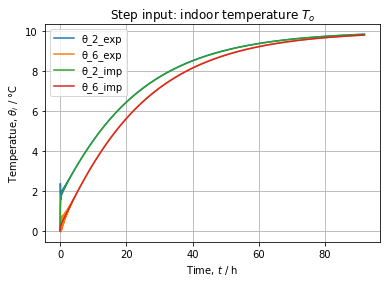

In [122]:
fig, ax = plt.subplots()
ax.plot(t / 3600, y_exp[0,:].T, t / 3600, y_exp[1,:].T, t / 3600, y_imp[0,:].T, t / 3600, y_imp[1,:].T)
ax.set(xlabel='Time, $t$ / h',
       ylabel='Temperatue, $θ_i$ / °C',
       title='Step input: indoor temperature $T_o$')
ax.legend(['θ_2_exp', 'θ_6_exp', 'θ_2_imp', 'θ_6_imp'])
ax.grid()
plt.show()

> Figure 5. Step response to indoor temperature by using Euler
[implicit](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Backward_Euler_method)
and
[explicit](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Euler_method) integration.

The value the indoor temperature obtained after the [settling time](https://en.m.wikipedia.org/wiki/Settling_time) is almost equal to the value obtained in steady-state.

In [123]:
print('Steady-state indoor temperature obtained with:')
print(f'- DAE model: {float(θ[6]):.4f} °C')
print(f'- state-space model: {float(yss[0]):.4f} °C')
print(f'- steady-state response to step input: {float(y_exp[0:1, -1]):.4f} °C')

Steady-state indoor temperature obtained with:
- DAE model: 10.0000 °C
- state-space model: 10.0000 °C
- steady-state response to step input: 9.8483 °C


We find a temperature equal or close to 10°C for the 3 models studied.

## Room for improvement


### Electrical scheme of the building

![Figure3](./schema_reel.jpg)
> Figure 3. Schéma électrique réel 